In [26]:
# Modules used in this notebook
import bs4
import datetime
import pandas as pd
import requests
import time
import pprint as pp
from IPython.core.display import display, HTML, Image

# Web Scraping using Requests and Beautiful Soup
(A significant portion of this material was adapted from Dr. Nick Freeman's workshop on Web-scraping and from Dr. Gregory Bott's Python Data Acquisition Course).a simple quotes siteF fre, and from Wikipedia.

In this notebook, we will see how we can use Python to harvest data from HTML. In particular, we will be using the python `requests` and `beautifulsoup` libraries to request and parse financial data from a simple quotes site, from Yahoo Finance, and from Wikipedia.

## Why Scrape?
Sometimes the data you require is not available in a structured, downloadable format. Often the most current data is available only on a web site. This notebook demonstrates how to "scrape" data from web sites using several different methods.

> If you understand how to web scrape, any available data on the web is a database for you!!

> **Should I use RegeX (regular expressions) to parse web data?**
> Although extracting patterned data from a text file is directly in the wheelhouse of RegEx, I recommend *against* using it to parse HTML. Crafting an expression that returns all desired strings while excluding all undesired strings is likely to fail. HTML pages vary widely and will return or exclude data in ways you cannot anticipate. Instead, use a library such as Beautiful Soup, to parse HTML.

## Before Scraping
Scraping a web site is not always the best option. Consider the following questions prior to scraping:
1. Does the web site in question allow scraping? (check the robots.txt)
2. Am I able to adhere to the requests of the web site (again, see robots.txt)?
3. Is scraping the easiest, most efficient, or most reliable method? Copy/paste? API? Download data file?
4. Is it ethical to scrape this information?

## HTML Knowledge
Although it's not necessary to be an HTML expert, having a strong grasp of how HTML works is helpful if you intend to extract information from a web page.

There are many HTML tutorials available, but one of the most concise options is W3Schools (https://www.w3schools.com/html/). 

## Viewing Source HTML
To determine the best method for extracting data from an HTML page, you must view the HTML. To view HTML using Firefox or Chrome, right-click the page and then click **View page source** (to view the entire page as a flat file) or click **Inspect** (to view an HTML inspection tool to navigate the page elements).


## Status codes
Use HTML status codes to better understand how a web server is responding to a request and to take action based on the response. Below is a graphic of HTML status codes.

![](images\HTTP_status_codes.gif)

## Install Requests
We'll use the `requests` library to obtain status codes, headers, and content from a web server and then use `beautifulsoup` to make sense of it. First, a quick review of how web browsers use HTTP to obtain information via request-response. When you type a URL into your browser, the browser makes a request from the destination web server and receives a response consisting of headers, a status code, and the content.

![](images\request_response.png)

To install requests, use conda:
```Python
conda install requests
```
After you have imported `requests`, use it to retrieve content such as the university's home page.

In [2]:
r = requests.get('https://www.ua.edu')

# Print the HTML response code given by the server
print("HTML status code:",r,"\n")

# Print the first 750 characters of the text returned
print(r.text[:750])

HTML status code: <Response [200]> 

<!DOCTYPE html>
<!--[if IE 8]>
<html id="ie8" lang="en-US">
<![endif]-->
<!--[if IE 9]>
<html id="ie9" lang="en-US">
<![endif]-->
<!--[if !IE]><!-->
<html lang="en-US">
<!--<![endif]-->
<head>
	<title>The University of Alabama</title>

		
	

	<meta charset="utf-8">
	<meta http-equiv="X-UA-Compatible" content="IE=edge">
	<meta name="viewport" content="width=device-width, initial-scale=1.0">
	<meta name="description" content="Official Web Site of The University of Alabama. Founded in 1831 as the state's flagship university, UA is a student-centered research university and academic community united in its commitment to enhancing the quality of life for all Alabamians.">
	<meta property="og:title" content="The University of Alabama" />
	<meta p


## Ethical Scraping
Although the "rights" to scrape publicly available data is debatable, we will not have that debate in our class. Instead, we will respect the wishes of those providing the data. If and how a site should be scraped should be communicated in a file called `robots.txt` and located at the root of the site.

Below is the Robots.txt file for the university's web site. It disallows several locations.

In [3]:
# UA.edu example using error handling
try:
    r = requests.get('https://www.ua.edu/robots.txt')
    r.raise_for_status()  # Raises a HTTPError if the status is 4xx, 5xxx
except (requests.exceptions.ConnectionError, requests.exceptions.Timeout) as e:
    print("No response from server")
except requests.exceptions.HTTPError as e:
    print(e)
else:
    print(r.text)

User-agent: *
Disallow: /api
Disallow: /cache
Disallow: /docs
Disallow: /inc
Disallow: /templates
Disallow: /academics/catalogs/catalog02
Disallow: /academics/catalogs/catalog04
Disallow: /academics/catalogs/catalog06
Disallow: /academics/catalogs/catalog08
Disallow: /academics/catalogs/catalog10


Now that we've seen `requests` in action, to get a better understanding of http requests, we will first target the website `httpbin.org`. The same person who developed `requests` and `requests-html` also created `httpbin.org`. The site enables developers to test their requests before deploying applications. The following code block: 
1. creates a variable named `target_url` that points an area of `httpbin.org` that allows users to test **GET** requests, 
2. makes a **GET** request using the `get` method available in the python requests package and stores the response in a variable named `r`, and 
3. prints the content of the `r` object in *JavaScript Object Notation* format (json). 

In [4]:
# 1) specify target_url 
target_url = 'http://httpbin.org/get'

# 2) make request
r = requests.get(target_url)

# 3) print response as json
print(r.json())

{'args': {}, 'headers': {'Accept': '*/*', 'Accept-Encoding': 'gzip, deflate', 'Host': 'httpbin.org', 'User-Agent': 'python-requests/2.23.0', 'X-Amzn-Trace-Id': 'Root=1-5f08b5af-daa260e6bba4de2ed5eed27e'}, 'origin': '130.160.124.4', 'url': 'http://httpbin.org/get'}


## User Agent and Referer Headers
Note that the json representation returned is a python dictionary. Inspecting the dictionary, we can see that there are keys for `args`, `headers`, `origin`, and `url`. The values in these keys give us an idea of some of the information that we transmit when making http requests. Moreover, we can control this information to some degree. To demonstrate this, we will look into how we can modify the headers that we send with a request. Specifically, we will modify our `User-Agent` and add a referer. Information on valid http request headers can be found at https://developer.mozilla.org/en-US/docs/Web/HTTP/Headers. 

Before we demonstrate how to modify the user agent and referer headers, let's understand the role that they play in an http request:
- `User-Agent`: Contains a characteristic string that allows the network protocol peers to **identify the application type, operating system, software vendor or software version of the requesting software user agent**. 
- `Referer`: The address of the previous web page from which a link to the currently requested page was followed.

Note that a website that we are making a request to can use the two headers we are considering to determine if we are a real user or a computer program. Specifically, as we can see in the response we received earlier, the default User-Agent used by the requests package show that we are making the request using the package. A website wishing to deter programmatic access can easily detect and deny such requests. Also, a request may seem more realistic if we are referred from a search engine such as Google. To modify these headers, we need to pass a dictionary of headers when we make a request. The following code demonstrates how this can be done. Specifically, we:

1. Define a variable named `my_user_agent`, which stores a string with a realistic value, 
2. Define a dictionary object named `headers`,
3. Add the defined user-agent variable, 
4. Specify a `Referer` header that suggests we were referred, i.e., made the request from, the Google search engine.
5. Make the same request as before with our new headers, and
6. Print the response as json.

The printed output below shows that our headers were correctly modified. Moreover, our request will now look more realistic to a target website. We will now look at how to pass parameters with a request. This is very common when working with web APIs, where the parameters are used to filter the data returned by the request and, oftentimes, to authenticate users. Similar to how we specified headers, we can specify parameters by passing a dictionary of parameters when we make the request. The following code block demonstrates this approach.

In [5]:
my_user_agent = 'Mozilla/5.0 (Windows NT 10.0; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/79.0.3945.130 Safari/537.36'

my_headers = {'User-Agent': my_user_agent, 
             'Referer': 'https://www.google.com'}

r = requests.get(target_url, headers = my_headers)

print(r.json())

{'args': {}, 'headers': {'Accept': '*/*', 'Accept-Encoding': 'gzip, deflate', 'Host': 'httpbin.org', 'Referer': 'https://www.google.com', 'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/79.0.3945.130 Safari/537.36', 'X-Amzn-Trace-Id': 'Root=1-5f08b5b0-18d942c301c96ab7733a0586'}, 'origin': '130.160.124.4', 'url': 'http://httpbin.org/get'}


In [6]:
# Define a test parameter, param1
my_params = {'param1': 'my_param_value'}

# Make the request, passing headers and parameters
r = requests.get(target_url, 
                 headers = my_headers, 
                 params = my_params)

# Print the response as json
print(r.json())

{'args': {'param1': 'my_param_value'}, 'headers': {'Accept': '*/*', 'Accept-Encoding': 'gzip, deflate', 'Host': 'httpbin.org', 'Referer': 'https://www.google.com', 'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/79.0.3945.130 Safari/537.36', 'X-Amzn-Trace-Id': 'Root=1-5f08b5b1-b6f9ae2b939229ea40a35047'}, 'origin': '130.160.124.4', 'url': 'http://httpbin.org/get?param1=my_param_value'}


Notice that the response output includes our parameters as `args`. Also notice that the `url` value has been updated. In particular, the string `?param1=my_param_value` was appended to the end of our `target_url`.

### Simple Scraping - Quote of the Day
Start by navigating to the page that you want to scrape and obtaining its URL. For this example, we want to scrape the quoteof the day from WisdomQuotes.com. The URL is: http://wisdomquotes.com/quote-of-the-day/

In [7]:
url = "http://wisdomquotes.com/quote-of-the-day/"

## Supply a header to the web server

In [8]:
# Unless you send a header, a web server may reject your request
headers = {'User-Agent' : 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/71.0.3578.98 Safari/537.36'}

#Request page, send headers
r = requests.get(url, headers=headers)

print(str(r.content)[:1000])

b'<!DOCTYPE html><html lang="en-US"\n prefix="og: https://ogp.me/ns#" ><head> <script>(function(w,d,s,l,i){w[l]=w[l]||[];w[l].push({\'gtm.start\':\nnew Date().getTime(),event:\'gtm.js\'});var f=d.getElementsByTagName(s)[0],\nj=d.createElement(s),dl=l!=\'dataLayer\'?\'&l=\'+l:\'\';j.async=true;j.src=\n\'https://www.googletagmanager.com/gtm.js?id=\'+i+dl;f.parentNode.insertBefore(j,f);\n})(window,document,\'script\',\'dataLayer\',\'GTM-TFN6FQV\');</script> <meta charset="UTF-8"><meta name="viewport" content="width=device-width, initial-scale=1"><meta name="msvalidate.01" content="18DDC7EE000F2D2304FCFD71B1F9B110" /><link rel="preload" as="style" onload="this.onload=null;this.rel=\'stylesheet\'" id="ao_optimized_gfonts" href="https://fonts.googleapis.com/css?family=Oxygen:400,300,700&amp;display=swap" /><link rel="profile" href="http://gmpg.org/xfn/11"><link rel="pingback" href="https://wisdomquotes.com/xmlrpc.php"><link rel="apple-touch-icon" sizes="180x180" href="https://wisdomquotessec

## Beautiful Soup
The idea of 'soup' is unordered stuff in a container (aka a soup). Specifically, it refers to malformed tags. The term apparently originated from Tag Soup, an interpreter that was able to handle messy HTML/SGML markup, much like Python's Beautiful Soup.

We'll use `requests` to obtain HTML, check status, send headers, etc., and then use Beautiful Soup (imported as `bs4`) to make sense of, or parse the HTML.

## Installing Beautiful Soup
To install the beautiful soup package (bs4) use pip.
```
conda install bs4
```

Next, inpsect the HTML to find a unique method to identify the information you wish to extract.

All quotes are prefaced with "blockquote", which makes it easy to filter all the quotes on the page.

Use the ```find_all()``` method to return a list of quotes.

In [9]:
# Use .text to return string (.content returns bytes, .text returns string)
soup = bs4.BeautifulSoup(r.content, 'html.parser')

soup.title # Print the page title to confirm we have successfully parsed the web page

<title>Quote of the Day - Wisdom Quotes</title>

In [10]:
# Inspect the HTML to find a consistent (and hopefully unique) pattern for the quotes
quotes = soup.find_all("blockquote")

The find_all method returns a result set, which can be used like a list.

In [11]:
print(type(quotes))

<class 'bs4.element.ResultSet'>


In [12]:
# Print the 5th quote
print(quotes[4])

<blockquote><p>Somewhere, something incredible is waiting to be known. Sharon Begley</p></blockquote>


In [13]:
print(quotes[2].text)

Men must live and create. Live to the point of tears. Albert Camus


Loop through the list of quotes and print the text attribute of the element.

In [ ]:
for quote in quotes:
    print("-----------------------------------")
    print(quote.text)

In [15]:
for quote in quotes:
    if "children" in quote.text:
        print("-----------------------------------")
        print(quote.text)

-----------------------------------
Farts are like children, I’m proud of mine and disgusted by yours. Bill Murray
-----------------------------------
While we try to teach our children all about life, our children teach us what life is all about. Angela Schwindt


## Find by tag and class
Often the information that you need is not labled by tag alone. For example, if you wanted to extract quotes from GoodReads, you could not use tag alone. All the quotes on the page are within div tags, but are uniquely identifed by class name.

In [17]:
goodread_images = soup.find_all("img")

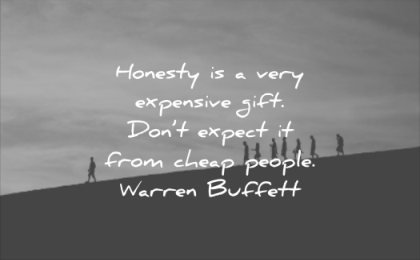

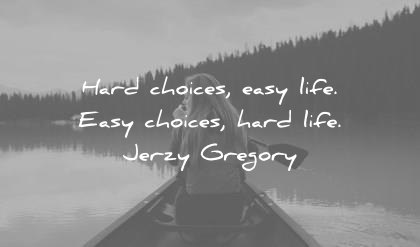

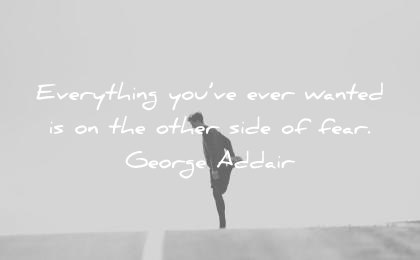

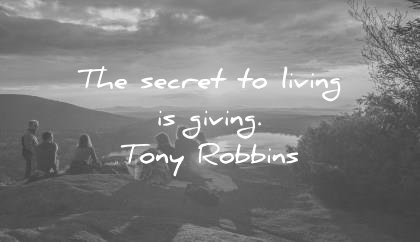

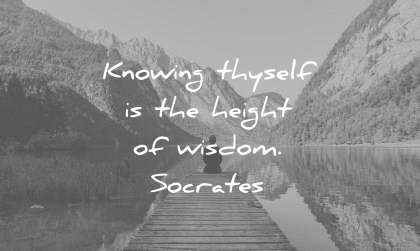

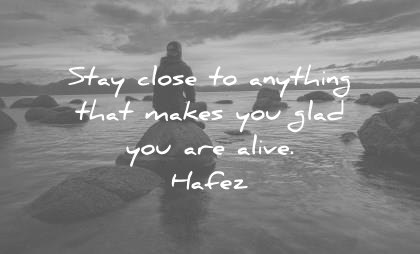

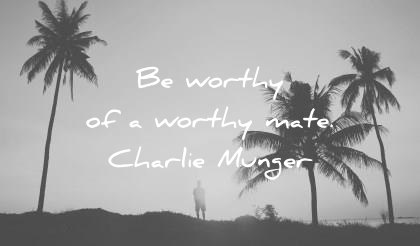

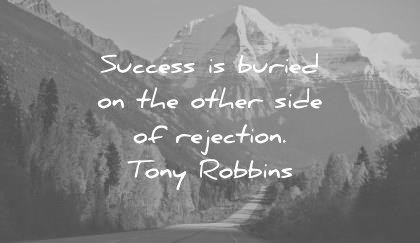

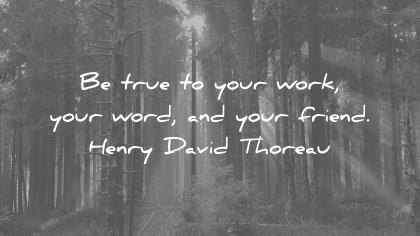

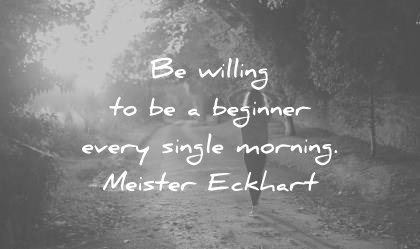

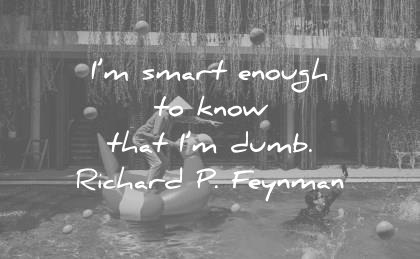

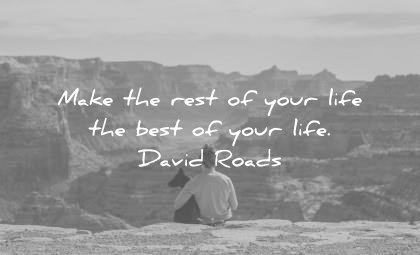

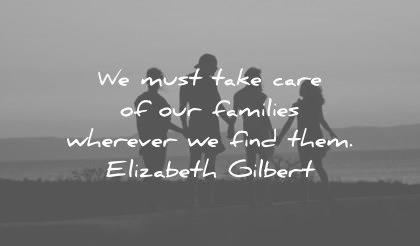

In [29]:
for link in soup.select("img[src^=http]"):
        lnk = link["src"]
        display(Image(lnk))

### Yahoo Finance Robots.txt file
We will be harvesting data from `https://finance.yahoo.com`. So, before we begin scraping, let's first look at the `robots.txt` file published for the site to see if there is any activity that is specifically *disallowed* or if any additional guidelines for access are given (e.g., maximum rate of scraping). The following code block makes a **GET** request for the site's `robots.txt` file and prints the returned text.

In [ ]:
r = requests.get('https://finance.yahoo.com/robots.txt')
print(r.text)

As you can see the `robots.txt` file specifies several paths that are disallowed for all user-agents. This is indicated by the `User-agent: *` line. However, also note that the files provides several sitemaps that actually help programs determine the layout of the site. We will use one of these sitemaps to help us access stock information for companies operating in specific sectors. Before doing this, let's store a list of prohibited paths so that we can ensure we do not volate the `robots.txt` directives.

In [ ]:
prohibited_paths = []
for statement in r.text.split('\n'):
    if 'Disallow:' in statement:
        current_path = statement.strip('Disallow: ')
        prohibited_paths.append('https://finance.yahoo.com' + current_path)
prohibited_paths

The following code block makes a **GET** request for the first sitemap. The response from this request is stored in the variable `r`. We use the `content` attribute of this response to get a *bytes* representation of the reponse and use the *BeautifulSoup* library to convert this data into a `soup` object. We print a *prettified* version of the first 1,000 characters of this object. 

In [ ]:
r = requests.get('https://finance.yahoo.com/sitemap_en-us_desktop_index.xml')

soup = bs4.BeautifulSoup(r.content)

#print(soup.prettify()[:1000])
pp.pprint(str(soup)[2500:4500]) # Print starting from 2500 characters up to 4500 characters

There are several URLs of interest that follow the form ` https://finance.yahoo.com/sector/...` e.g., https://finance.yahoo.com/sector/ms_basic_materials. These pages report stock information for top companies operating in the associated sector. The following code block shows how we can use BeautifulSoup to extract all of the `loc` elements that include the word `sector` in the associated text and store them in a list called `sector_urls`. Note how we are insuring that the returned URLS do not match any of the partial strings stored in our list of `prohibited_paths`.

In [ ]:
prohibited_paths

In [ ]:
sector_urls = []
for loc_tag in soup.find_all('loc'):
    if 'sector' in loc_tag.text:
        prohibited = False
        for path in prohibited_paths:
            if path in loc_tag.text:
                print('Path prohibited!')
                prohibited = True
        if not prohibited:
            print(f'{loc_tag.text} not prohibited')
            sector_urls.append(loc_tag.text)

The following code block prints the first URl in our `sector_urls` list. If you visit the site with your web browser, you sill see that the page displays a table of related stocks and associated information.

In [ ]:
current_sector_loc = sector_urls[0]
print(sector_urls[0])

Inspecting the HTML of the previous URL, you will see that the table is enclosed in a set of `<table>` tags. The following code block 
1. requests the HTML associated with the URL, 
2. converts the response to a `soup` object, 
3. identifies all elements enclosed in `<table>` tags and stores the associated HTML in a list named `tables`, 
4. prints the number of items in the `tables` object, and
5. prints the first 5,000 characters of the first item in the `tables` list.

Note how the HTML for the tables uses the `<tr>`, `<th>`, and `<td>` to achieve the desired structure.

In [ ]:
current_sector_loc = sector_urls[0]

r = requests.get(current_sector_loc)
soup = bs4.BeautifulSoup(r.content)

tables = soup.find_all('table')

print(f'The tables object has {len(tables)} item(s).\n')

# Raw print
print(str(tables[0])[:1000])

In [ ]:
# Prettify printing
print(tables[0].prettify()[:500])

In [ ]:
# Render as HTML
display(HTML(str(tables[0])[:15000]))

The following code block shows how we can use a loop to iterate over all of the sectors, collecting the data stored in the table and using it to construct a pandas `DataFrame`.

In [ ]:
data_list = []
for current_sector_loc in sector_urls:
    r = requests.get(current_sector_loc)
    soup = bs4.BeautifulSoup(r.content)

    for current_row in soup.find_all('tr'):
        row_list = []
        for current_data in current_row.find_all('td'):
            row_list.append(current_data.text)
        if row_list:
            row_list.append(current_sector_loc.split('/')[-1])
            row_list.append(datetime.datetime.now().strftime('%m-%d-%Y %H:%M:%S'))
            data_list.append(row_list)
    
columns = ['Symbol', 'Name', 'Price', 'Change', '%Change', 
           'Volume', 'Avg Vol. (3 mnth)', 'Market Cap', 
           'PE Ratio', '52 Week Range', 'Sector', 'Scrape Time']

all_data = pd.DataFrame(data_list, columns = columns)
all_data.head()

## Wikipedia

Just to demonstrate a (slightly) more complex harvesting task, let's write some code to collect headlines from Wikipedia pages. As before, let's first check the `robots.txt` file, which is much more extensive.

In [ ]:
r = requests.get('https://en.wikipedia.org/robots.txt')
print(r.text)

The following code block creates a list of prohibited paths for a general web scraping application and displays the first 30 items in the list.

In [ ]:
prohibited_paths = []
current_user_agent = None
for line in r.text.split('\n'):
    if 'User-agent' in line:
        current_user_agent = line.strip('User-agent: ')
    if current_user_agent is not None:
        if current_user_agent.strip() == '*':
            if 'Disallow: ' in line:
                prohibited_paths.append(line.strip('Disallow: '))
                
prohibited_paths[:30]

If you browse through a few Wikipedia pages, you will notice that the links use a very consitent naming pattern. Suppose, we want to try the phrases in the `words_to_try` object.

In [ ]:
words_to_try = ['Python_Programming', 
                'Robust_optimization',
                'Nonparametric_regression',
                'Data_warehouse',
                'tHis_wIll_nOt_wErk',
                'Integer_programming',
                'Sentiment_Analysis']

base_url = 'https://en.wikipedia.org/wiki/'

The following code attempts to access the pages defined by our `words_to_try` object and returns a list of the headlines along with the associated word.

In [ ]:
headlines = []

for current_word in words_to_try:
    current_url = base_url + current_word
    
    try:
        r = requests.get(current_url)
        soup = bs4.BeautifulSoup(r.content)

        for headline in soup.find_all('span', attrs = {'class':'mw-headline'}):
            if 'See also' in headline:
                break
            else:
                headlines.append([headline.text, current_word])
    except Exception as e:
        print(f'{type(e).__name__} on {current_url}')
    
    time.sleep(1)
    
for row in headlines:
    print(row)